In [ ]:
from PIL import Image
import requests
import torch
import numpy as np
from transformers import CLIPProcessor, CLIPModel, CLIPFeatureExtractor, CLIPImageProcessor
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, confusion_matrix,precision_score, recall_score, f1_score


In [ ]:
#definition of CLIP model
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


In [ ]:
#This is just to load the images easily
from torchvision import datasets, transforms
train_path = 'train/'
test_path = 'test/'

#CLIP takes 224 224 images
transforms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

train_dataset = datasets.ImageFolder(root=train_path, transform=transforms)
print('Training data size = {}'.format(len(train_dataset)))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, num_workers=1)

test_dataset = datasets.ImageFolder(root=test_path, transform=transforms)
print('Test data size = {}'.format(len(test_dataset)))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, num_workers=1)

print('Labels = {}'.format(train_dataset.class_to_idx))

Training data size = 21415
Test data size = 4053
Labels = {'norm': 0, 'weap': 1}


In [ ]:
#creates a list with embeddings of each image batch : length 168, 128 images per batch
def create_embeddings(dataloader, filename=None):
    
    embeddings_list = []

    for i, (images, labels) in enumerate(dataloader):
        with torch.no_grad():
            inputs = processor(text=None, images=images, return_tensors="pt", )["pixel_values"]
            embeddings = model.get_image_features(inputs)
            embeddings_list.append(embeddings.detach().numpy())

        if i % 10 == 0 : 
            
            print(i / len(dataloader))#np.save(f"embeddings/{i}_{len(train_dataloader)}.npy", np.concatenate(embeddings_list))
    
    if filename is not None : 
        np.save(f"embeddings/{filename}.npy", np.concatenate(embeddings_list))
    return embeddings_list

# test_embeddings = create_embeddings(test_dataloader, "test_embeddings")



In [ ]:
#if embeddings are already saved in embeddings/167_168.npy : 

def transform_list(embeddings, batch_size=128):
    embeddings_list = []
    for i in range(embeddings.shape[0] // batch_size + 1):
        embeddings_list.append(embeddings[batch_size*i:min(batch_size*(i+1), embeddings.shape[0])])
    return embeddings_list

train_embeddings = np.load("embeddings/167_168.npy")
train_embeddings_list = transform_list(train_embeddings)

test_embeddings = np.load("embeddings/test_embeddings.npy")
test_embeddings_list = transform_list(test_embeddings)

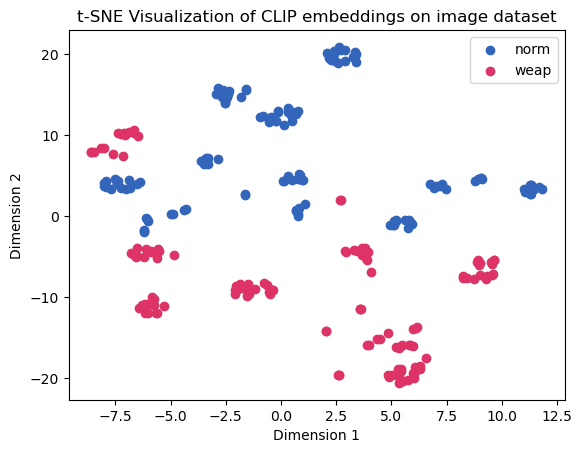

In [ ]:
#try to see if the 512-vectors clusters can be separated between weapon and no weapon
#weapon and normal images seem separable.

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30.0, random_state=0)
X_tsne = tsne.fit_transform(np.concatenate([train_embeddings_list[0],train_embeddings_list[-2]]))
c = np.concatenate([np.zeros(train_embeddings_list[0].shape[0]), np.ones(train_embeddings_list[-2].shape[0])])
plt.scatter(X_tsne[:128, 0], X_tsne[:128, 1], c = '#3366BB', label='norm')
plt.scatter(X_tsne[128:, 0], X_tsne[128:, 1], c = '#DD3366', label='weap')
plt.title("t-SNE Visualization of CLIP embeddings on image dataset")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.show()


In [ ]:
#creates the label array, it is simple because train_loader has no shuffle
labels=np.concatenate([np.zeros((7734)), np.ones((13681))]) #train loader is not shuffled
labels_test = np.concatenate([np.zeros((2191)), np.ones((1862))])

#slices the label array to have the same shapes as in embeddings_list
labels_list = transform_list(labels)

In [ ]:

#create a very simple shallow MLP
net = nn.Sequential(
    nn.Linear(512, 1),  #embeddings are 512-vectors 
    nn.Sigmoid()  
)

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(net.parameters(), lr=0.005)
losses, accuracies, test_acc = [], [], []
n = len(train_embeddings_list)

#training loop of MLP
print("epoch | BCE Loss | train_acc | test_acc")
for epoch in range(30):
    epoch_loss = 0 
    epoch_acc = 0 
    for i in np.random.permutation(range(n)): #mixes the 0 and 1 batches
        X, y = train_embeddings_list[i], labels_list[i]
        X, y = torch.Tensor(X), torch.Tensor(y).unsqueeze(1)
        y_pred = net(X)
        loss = criterion(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        y_bin = (y_pred.detach().numpy() > 0.5).astype(np.int8)
        epoch_acc += accuracy_score(y.detach().numpy(), y_bin)
        epoch_loss += loss.item() 

    epoch_loss /= n
    epoch_acc /= n
    losses.append(epoch_loss)
    accuracies.append(epoch_acc)
    test_acc.append(test_accuracy(net))
    
    if epoch % 5 == 0:
        print(f"{epoch} | {epoch_loss} | {epoch_acc} | {test_acc[-1]}")

def test_accuracy(net):
    return accuracy_score((net(torch.Tensor(test_embeddings)).detach().numpy() > 0.5).astype(np.int8), labels_test)

epoch | BCE Loss | train_acc | test_acc
0 | 0.4770266673461135 | 0.7582393734737485 | 0.7456205280039477
5 | 0.32330331822768565 | 0.8544194520757021 | 0.7641253392548729
10 | 0.28544671306874425 | 0.8725234184218559 | 0.6777695534172218
15 | 0.28116086133412044 | 0.8756915827228328 | 0.7327905255366395
20 | 0.26079404492685127 | 0.8908777854090355 | 0.6824574389341229
25 | 0.2607767389244622 | 0.8845664968711844 | 0.7100912904021712


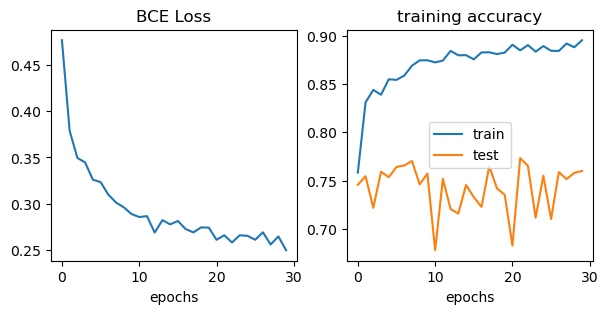

In [ ]:
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(1,2,figsize=(7, 3))
plt.subplot(1,2,1)
ax[0].plot(losses)
ax[0].set_title("BCE Loss")
ax[0].set_xlabel("epochs")
ax[1].set_title("training accuracy")
ax[1].plot(accuracies, label = "train")
ax[1].plot(test_acc, label="test")
ax[1].set_xlabel("epochs")
ax[1].legend()
plt.show()

In [ ]:
#might be long if taking all the images
from sklearn import svm

# Instantiate SVM model
clf = svm.SVC(kernel='linear')
# Train the model on your training data
clf.fit(train_embeddings, labels)


SVC(kernel='linear')

In [ ]:
#estimates the similarity between all images and text_weap and text_norm. Creates a list with an array for each batch, of size 128x2

text_weap = "a photo of someone with a weapon"
text_norm = "a photo of a person"
  
    
def evaluate_similarity(dataloader, filename=None):
    
    probs_list = []

    for i, (images, _) in enumerate(dataloader):
        with torch.no_grad():
         
            inputs = processor(text=[text_norm, text_weap], images=images, return_tensors="pt", padding=True)
            outputs = model(**inputs)
            logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
            probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities       

            probs_list.append(probs.detach().numpy())

        #print the average label of the batch
        #print((torch.argmax(probs, axis = 1)).sum() / probs.shape[0])
        if i % 10 == 0 : 
            print(i / len(dataloader))
    if filename is not None : 
        np.save(f"embeddings/{filename}.npy", np.concatenate(probs_list))
    
    return probs_list

evaluate_similarity(train_dataloader, filename="weapon_probs")
#evaluate_similarity(test_dataloader, filename="weapon_probs_test")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
0.0
0.05952380952380952
0.11904761904761904
0.17857142857142858
0.23809523809523808
0.2976190476190476
0.35714285714285715
0.4166666666666667
0.47619047619047616
0.5357142857142857
0.5952380952380952
0.6547619047619048
0.7142857142857143
0.7738095238095238
0.8333333333333334


In [ ]:
#creates the weapon_probs array
probs = np.load("embeddings/weapon_probs.npy")
probs_list = transform_list(probs)

probs_test = np.load("embeddings/weapon_probs_test.npy")
probts_test_list = transform_list(probs_test)

In [ ]:
def print_metrics(y_pred, labels) : 
    print(f"Accuracy: {accuracy_score(y_pred, labels):.3f}")
    print(f"Precision: {precision_score(y_pred, labels):.3f}")
    print(f"Recall: {recall_score(y_pred, labels):.3f}")
    print(f"F1-Score: {f1_score(y_pred, labels):.3f}")        
    print(f"Confusion matrix: {confusion_matrix(y_pred, labels)}")

In [ ]:
y_pred_test_mlp = (net(torch.Tensor(test_embeddings)).detach().numpy() > 0.5).astype(np.int8)
print("Metrics for CLIP-MLP")
print_metrics(y_pred_test_mlp, labels_test)

Metrics for CLIP-MLP
Accuracy: 0.760
Precision: 0.881
Recall: 0.686
F1-Score: 0.771
Confusion matrix: [[1440  222]
 [ 751 1640]]


In [ ]:
y_pred_test_svm = clf.predict(test_embeddings)
print("Metrics for CLIP-SVM")
print_metrics(y_pred_test_svm, labels_test)

Metrics for CLIP-SVM
Accuracy: 0.732
Precision: 0.923
Recall: 0.646
F1-Score: 0.760
Confusion matrix: [[1248  144]
 [ 943 1718]]


In [ ]:
y_pred_clip = np.argmax(1-probs, axis=1)  
print("Metrics for CLIP-Sim (train dataset)")
print_metrics(y_pred_clip, labels)

Metrics for CLIP-Sim
Accuracy: 0.772
Precision: 0.792
Recall: 0.841
F1-Score: 0.816
Confusion matrix: [[ 5690  2844]
 [ 2044 10837]]


In [ ]:
y_pred_clip_test = np.argmax(probs_test, axis=1)  
print("Metrics for CLIP-Sim (test dataset)")
print_metrics(y_pred_clip_test, labels_test)

Metrics for CLIP-Sim (test dataset)
Accuracy: 0.715
Precision: 0.886
Recall: 0.637
F1-Score: 0.741
Confusion matrix: [[1250  213]
 [ 941 1649]]
